# Notebook for Extensions 1 and 2

This notebook includes replicating all extension 1 and 2 figures found in the report, gives more details about some assumptions made, and intermediate findings. Concretely:
1. Examples how to load the saved saliency models.
2. Evaluation of the classifier, brief analysis of MIMIC-III.
3. Use the classifier to correctly predict mortality of patients. Use the result to visualize examples of which temporal features are deemed important classifier as found by ExtremalMask and DynaMask methods (Figures 1a, 1b in our report).
4. Compute perturbations NN(x) and using them compute alternative saliency metric.
5. Reproduce Figure 5 from the original paper, compute same figure using new saliency metric. (Figures 2a, 2b in our report)
6. Visualize original data, perturbed data, and predicted mask. Do the same with new saliency metric as well. (Figures X in the report's Appendix)
7. Plot the components of perturbation of a univariate time series signal for in-depth understanding of the model. (Figures X in the report's Appendix)
8. Similar visualizations for synthetic HMM (Figures X in the report's Appendix) and ARMA datasets.

The exact extensions in our report are formulated as follows:

**Extension 1**. Using ExtremalMask, we propose a new metric for data saliency. Using this, we re-evaluate the information and entropy (defined in Section 3.4.1) on HMM

**Extension 2**. We visually analyze the saliency map using the new metric learned by ExtremalMask and its predecessor DynaMask on the MIMIC-III dataset. Furthermore, we compare the saliency of the top 5 most important features of the MIMIC-III dataset using these two saliency metrics.

**Note!** The data comes in the shape of (batch size, time series length, no. features). This means that if we want to visualize the first batch of data, we do `data[0].T`. Transpose is important to put features as rows to show time series data horizontally!

## MIMIC-III

All of these experiments have been done for the MIMIC-III *mortality* dataset (classification task), NOT the *blood pressure* part (regression task).

In [1]:
import numpy as np
import torch as th

# The default seed set in the tint experiments, and subsequently used by us
SEED = 42
# For this fold we have all methods saved, for some (like retain and deep lift)
# we forgot to save the fold 0
FOLD = 1

MIMIC_CKPT_DIR = "experiments/checkpoints/mimic_copy/"
# PICKLE_DIR = "experiments/pickles/"
PICKLE_DIR = MIMIC_CKPT_DIR
CLS_DIR = "experiments/checkpoints/mimic3_classifier/"

### Load MIMIC-III dataset

This is needed for evaluating models, visualizing multiple results, computing perturbations and new saliencies.

In [2]:
from pytorch_lightning import seed_everything
from tint.datasets import Mimic3

# Define the same variables as in the pipeline of main.py
deterministic = True
device = "cpu"
dataset_name = "mimic3"
model_name = "extremal_mask"
lambda_1 = 1.0
lambda_2 = 1.0
preservation_mode = True

if deterministic:
    seed_everything(seed=SEED, workers=True)

# Get accelerator and device
accelerator = device.split(":")[0]
device_id = 1
if len(device.split(":")) > 1:
    device_id = [int(device.split(":")[1])]

# Load data
mimic3 = Mimic3(n_folds=5, fold=FOLD, seed=SEED)
x_train_mimic = mimic3.preprocess(split="train")["x"].to(device)
x_test_mimic = mimic3.preprocess(split="test")["x"].to(device)
y_test_mimic = mimic3.preprocess(split="test")["y"].to(device)

Seed set to 42


In [3]:
import torch.nn as nn
from experiments.mimic3.mortality.classifier import MimicClassifierNet
from pytorch_lightning import Trainer
from tint.attr import ExtremalMask
from tint.attr.models import ExtremalMaskNet
from tint.models import MLP, RNN
from tint.utils.model_loading import get_model

# Create classifier
mimic3_cls = MimicClassifierNet(
    feature_size=31,
    n_state=2,
    hidden_size=200,
    regres=True,
    loss="cross_entropy",
    lr=0.0001,
    l2=1e-3,
)

# Train classifier
cls_trainer = Trainer(
    max_epochs=100,
    accelerator=accelerator,
    devices=device_id,
    deterministic=deterministic,
    logger=False,
)
mimic3_cls = get_model(
    cls_trainer,
    mimic3_cls,
    "classifier",
    dataset_name,
    SEED,
    FOLD,
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    datamodule=None,
    checkpoint_dir="experiments/checkpoints/mimic3_classifier/",
)

# Switch to eval
mimic3_cls.eval()

# Set model to device
mimic3_cls.to(device)

trainer = Trainer(
    max_epochs=500,
    accelerator=accelerator,
    devices=device_id,
    log_every_n_steps=2,
    deterministic=deterministic,
    logger=False,
)
extremal_mask_mask_net_mimic = ExtremalMaskNet(
    forward_func=mimic3_cls,
    preservation_mode=preservation_mode,
    model=nn.Sequential(
        RNN(
            input_size=x_test_mimic.shape[-1],
            rnn="gru",
            hidden_size=x_test_mimic.shape[-1],
            bidirectional=True,
        ),
        MLP([2 * x_test_mimic.shape[-1], x_test_mimic.shape[-1]]),
    ),
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    loss="cross_entropy",
    optim="adam",
    lr=0.01,
)
explainer = ExtremalMask(dataset_name, mimic3_cls, SEED, FOLD)
_attr = explainer.attribute(
    x_test_mimic,
    trainer=trainer,
    mask_net=extremal_mask_mask_net_mimic,
    batch_size=100,
)
extremal_mask_attr_mimic = _attr.to(device)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trying to load experiments/checkpoints/mimic3_classifier//mimic3_classifier_42_1.ckpt
classifier has loaded the saved weights on mimic3 dataset with fold = 1, if applicable, lambda 1 = 1.0 and lambda 2 = 1.0.
extremal_mask has loaded the saved weights on mimic3 dataset with fold = 1, if applicable, lambda 1 = 1.0 and lambda 2 = 1.0.


In [4]:
import numpy as np
from tint.attr import DynaMask
from tint.attr.models import MaskNet

trainer = Trainer(
    max_epochs=1000,
    accelerator=accelerator,
    devices=device_id,
    log_every_n_steps=2,
    deterministic=deterministic,
    logger=False,
)
mask = MaskNet(
    forward_func=mimic3_cls,
    perturbation="fade_moving_average",
    keep_ratio=list(np.arange(0.1, 0.7, 0.1)),
    deletion_mode=True,
    size_reg_factor_init=0.1,
    size_reg_factor_dilation=10000,
    time_reg_factor=0.0,
    loss="cross_entropy",
)
explainer = DynaMask(dataset_name, mimic3_cls, SEED, FOLD)
dyna_mask_attr_mimic, dyna_mask_mask_net_mimic = explainer.attribute(
    x_test_mimic,
    additional_forward_args=(True,),
    trainer=trainer,
    mask_net=mask,
    batch_size=100,
    return_best_ratio=False,
)
dyna_mask_attr_mimic = dyna_mask_attr_mimic.to(device)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


dyna_mask has loaded the saved weights on mimic3 dataset with fold = 1, if applicable, lambda 1 = None and lambda 2 = None.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [5]:
from tint.utils.perturbations import compute_alternative, compute_perturbations

# Batch size for dyna is also 100
(
    extremal_mimic_batch,
    extremal_perturbation_mimic,
    extremal_mask_attr_mimic_batch,
    extremal_x1_mimic,
    extremal_x2_mimic,
) = compute_perturbations(
    data=x_test_mimic,
    mask_net=extremal_mask_mask_net_mimic,
    perturb_net=extremal_mask_mask_net_mimic.net.model,
    batch_idx=0,
)
extremal_alternative_mimic = compute_alternative(
    batch=extremal_mimic_batch,
    mask=extremal_mask_attr_mimic_batch,
    perturbation=extremal_perturbation_mimic,
)

# Batch size for dyna is also 100
(
    dyna_mimic_batch,
    dyna_perturbation_mimic,
    dyna_mask_attr_mimic_batch,
    dyna_x1_mimic,
    dyna_x2_mimic,
) = compute_perturbations(
    data=x_test_mimic,
    mask_net=dyna_mask_mask_net_mimic,
    perturb_net=None,
    batch_idx=0,
)
dyna_alternative_mimic = compute_alternative(
    batch=dyna_mimic_batch,
    mask=dyna_mask_attr_mimic_batch,
    perturbation=dyna_perturbation_mimic,
)

The warning here is expected because the listed methods do not have a learned mask model.

### Load and evaluate MIMIC-III classifier (only possible with access to MIMIC-III dataset)

In [6]:
cls_trainer.test(mimic3_cls, dataloaders=mimic3)
print()

Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.913223147392273
       test_auroc             0.7833251953125
        test_loss           0.25653332471847534
        test_pre            0.5903614163398743
        test_rec            0.11835748702287674
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────



In [7]:
outcomes_train = mimic3.preprocess(split="train")["y"]
alive_train, dead_train = outcomes_train.unique(return_counts=True)[1]
total_train = len(outcomes_train)
print(f"Total patients in the training set: {total_train}")
print(
    f"Alive patients: {alive_train} ({alive_train/total_train * 100 :.2f}%), dead: {dead_train} ({dead_train/total_train * 100:.2f}%)"
)

Total patients in the training set: 18390
Alive patients: 16514 (89.80%), dead: 1876 (10.20%)


As we can see, the dataset is very imbalanced. We observe that the classifier has achieved a high accuracy (91.3%), but it is not that good if we note that 89.80% of the data points in the training dataset have negative labels. We should bear this result in mind when looking at our subsequent analysis.

### Figure out at which indices the classifier predicted a positive class

In [8]:
# Batch size = 32, that's why 144 predictions / epochs
predictions = cls_trainer.predict(mimic3_cls, dataloaders=mimic3.test_dataloader())

# Convert classification network's logits to concrete predictions
intermediate = np.array(predictions[0])
for i in range(1, len(predictions)):
    intermediate = np.append(intermediate, predictions[i], axis=0)

mimic_cls_predictions = th.argmax(th.tensor(intermediate), dim=1)

Predicting: |          | 0/? [00:00<?, ?it/s]

In [9]:
# Take only the dead patients
dead_indices = th.where(y_test_mimic == 1)[0]
# For which patients did the classifier correctly predict deaths?
correct_death_idx = dead_indices[
    th.where(y_test_mimic[dead_indices] == mimic_cls_predictions[dead_indices])[0]
]
correct_death_idx

tensor([   4,   64,  223,  316,  345,  399,  673,  687,  728,  747,  764,  928,
         954, 1030, 1073, 1171, 1235, 1317, 1430, 1527, 1680, 1718, 1778, 1801,
        1966, 1971, 1991, 2110, 2242, 2254, 2257, 2381, 2383, 2408, 2430, 2702,
        2717, 2777, 2838, 3045, 3086, 3095, 3113, 3136, 3173, 3262, 3422, 3449,
        3462, 3575, 3585, 3589, 3604, 3661, 3968, 3972, 3983, 4006, 4025, 4061,
        4155, 4256, 4281, 4420, 4483, 4517, 4581])

### Compute perturbations using the trained networks of ExtremalMask and DynaMask

In [10]:
from tint.utils.perturbations import compute_alternative, compute_perturbations

# Batch size for extremal was 100, which has idx = 0 if we want to visualize NEG_ID = 33 or POS_ID = 64
(
    extremal_mimic_batch,
    extremal_perturbation_mimic,
    extremal_mask_attr_mimic_batch,
    extremal_x1_mimic,
    extremal_x2_mimic,
) = compute_perturbations(
    data=x_test_mimic,
    mask_net=extremal_mask_mask_net_mimic,
    perturb_net=extremal_mask_mask_net_mimic.net.model,
    batch_idx=0,
)

extremal_alternative_mimic = compute_alternative(
    batch=extremal_mimic_batch,
    mask=extremal_mask_attr_mimic_batch,
    perturbation=extremal_perturbation_mimic,
    p=np.inf,
)

# Batch size for dyna is also 100
(
    dyna_mimic_batch,
    dyna_perturbation_mimic,
    dyna_mask_attr_mimic_batch,
    dyna_x1_mimic,
    dyna_x2_mimic,
) = compute_perturbations(
    data=x_test_mimic,
    mask_net=dyna_mask_mask_net_mimic,
    perturb_net=None,
    batch_idx=0,
)
dyna_alternative_mimic = compute_alternative(
    batch=dyna_mimic_batch,
    mask=dyna_mask_attr_mimic_batch,
    perturbation=dyna_perturbation_mimic,
    p=np.inf,
)

### Plot mask and alternative saliency for ExtremalMask and DynaMask methods for positive class (Figure 1a)

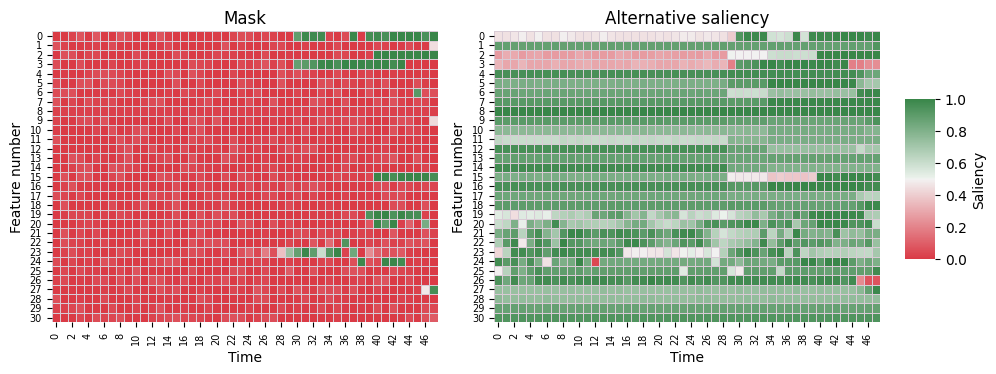

In [11]:
from tint.utils.plotting import plot_heatmap

POS_ID = 64  # This is an example of the indices found above
saliencies = {
    "ExtremalMask": extremal_mask_attr_mimic[POS_ID].T,
    "ExtremalMask, alternative saliency": extremal_alternative_mimic[POS_ID].T,
    # "DynaMask": dyna_mask_attr_mimic[POS_ID].T,
    # "DynaMask, alternative saliency": dyna_alternative_mimic[POS_ID].T,
}
plot_heatmap(
    saliencies,
    title=None,
    subtitles=["Mask", "Alternative saliency"],
    cbar_title="Saliency",
)

### Plot mask and alternative saliency for ExtremalMask and DynaMask methods for negative class (Figure 4 in the Appendix)

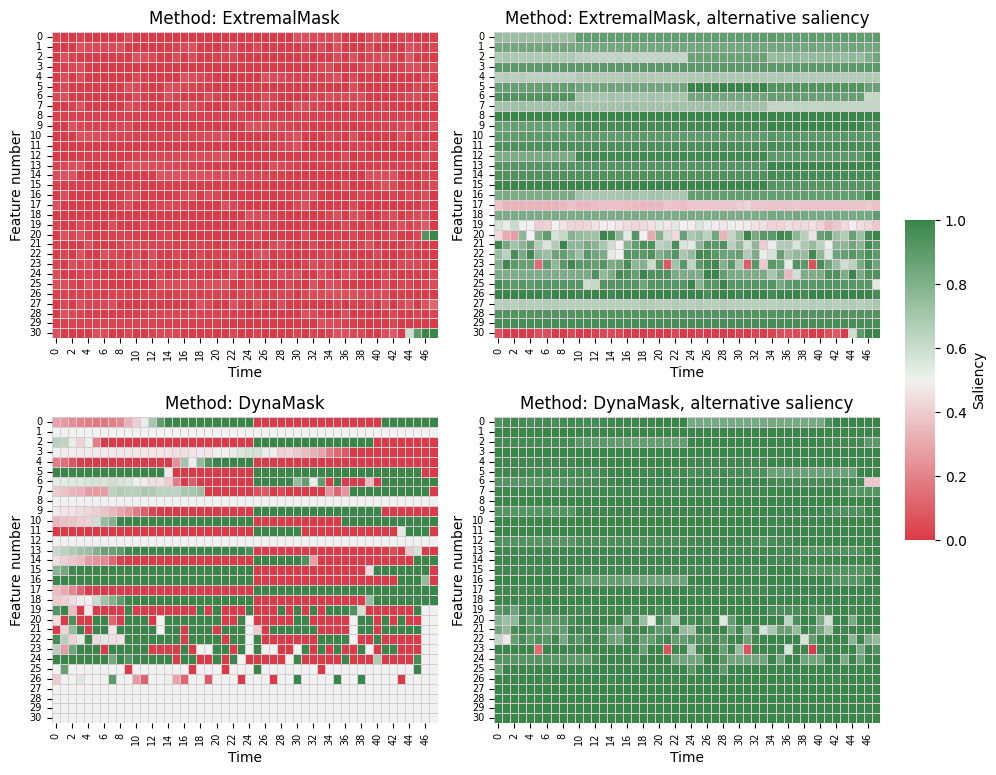

In [12]:
NEG_ID = 33
saliencies = {
    "ExtremalMask": extremal_mask_attr_mimic[NEG_ID].T,
    "ExtremalMask, alternative saliency": extremal_alternative_mimic[NEG_ID].T,
    "DynaMask": dyna_mask_attr_mimic[NEG_ID].T,
    "DynaMask, alternative saliency": dyna_alternative_mimic[NEG_ID].T,
}
plot_heatmap(saliencies, title=None, cbar_title="Saliency")

### Plot top k temporal features in the saliency map (Figure 1b)

In [13]:
POS_ID = 64  # This is an example of the indices found above
# Set how many top features to plot
important_ratio = 0.2
shp = extremal_alternative_mimic[0].shape
k = int(shp[0] * shp[0] * important_ratio)

# Compute top feature indices for the positive patient
top_mask_indices = extremal_mask_attr_mimic[POS_ID].reshape(-1).topk(k).indices
top_alt_indices = extremal_alternative_mimic[POS_ID].reshape(-1).topk(k).indices

# Start with a 0 saliency map and light up only the temporal features
# which are the top k
top_mask = th.zeros(shp[0] * shp[1])
top_mask[top_mask_indices] = 1
top_mask = top_mask.reshape(shp)
top_alt = th.zeros(shp[0] * shp[1])
top_alt[top_alt_indices] = 1
top_alt = top_alt.reshape(shp)

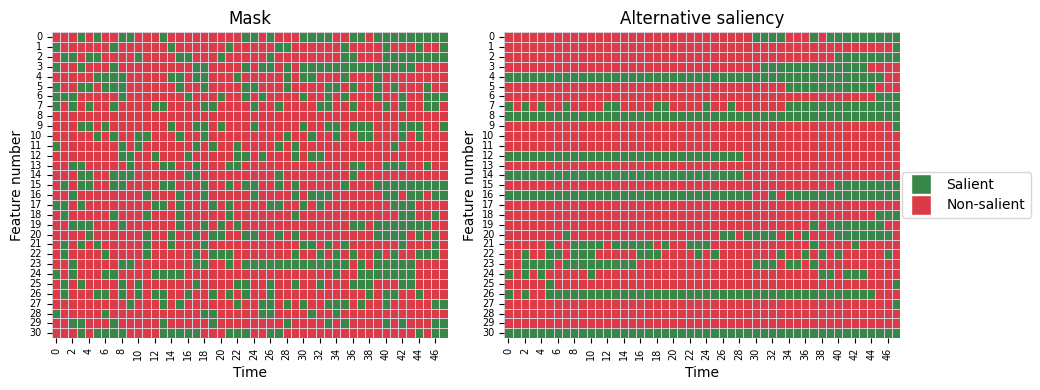

In [14]:
from tint.utils.plotting import plot_topk_heatmap

saliencies = {
    "Mask": top_mask.T,
    "Alternative saliency": top_alt.T,
}
plot_topk_heatmap(saliencies, subtitles=["Mask", "Alternative saliency"])

### Compare many explainer methods on a positive sample (Figure 5 in the Appendix)

We load the attributions all of which have been saved on Snellius to facilitate reproduction and save computational resources.

In [15]:
from tint.utils.model_loading import load_explainer

aug_occlusion_attr_mimic, _, _ = load_explainer(
    dataset_name="mimic3",
    method="augmented_occlusion",
    seed=SEED,
    fold=FOLD,
    pickle_dir=PICKLE_DIR,
)
deep_lift_attr_mimic, _, _ = load_explainer(
    dataset_name="mimic3",
    method="deep_lift",
    seed=SEED,
    fold=FOLD,
    pickle_dir=PICKLE_DIR,
)
integrated_gradients_attr_mimic, _, _ = load_explainer(
    dataset_name="mimic3",
    method="integrated_gradients",
    seed=SEED,
    fold=FOLD,
    pickle_dir=PICKLE_DIR,
)
retain_attr_mimic, _, _ = load_explainer(
    dataset_name="mimic3", method="retain", seed=SEED, fold=FOLD, pickle_dir=PICKLE_DIR
)

Could not find and load experiments/checkpoints/mimic_copy/mimic3_augmented_occlusion_mask_42_1
Could not find and load experiments/checkpoints/mimic_copy/mimic3_deep_lift_mask_42_1
Could not find and load experiments/checkpoints/mimic_copy/mimic3_integrated_gradients_mask_42_1
Could not find and load experiments/checkpoints/mimic_copy/mimic3_retain_mask_42_1


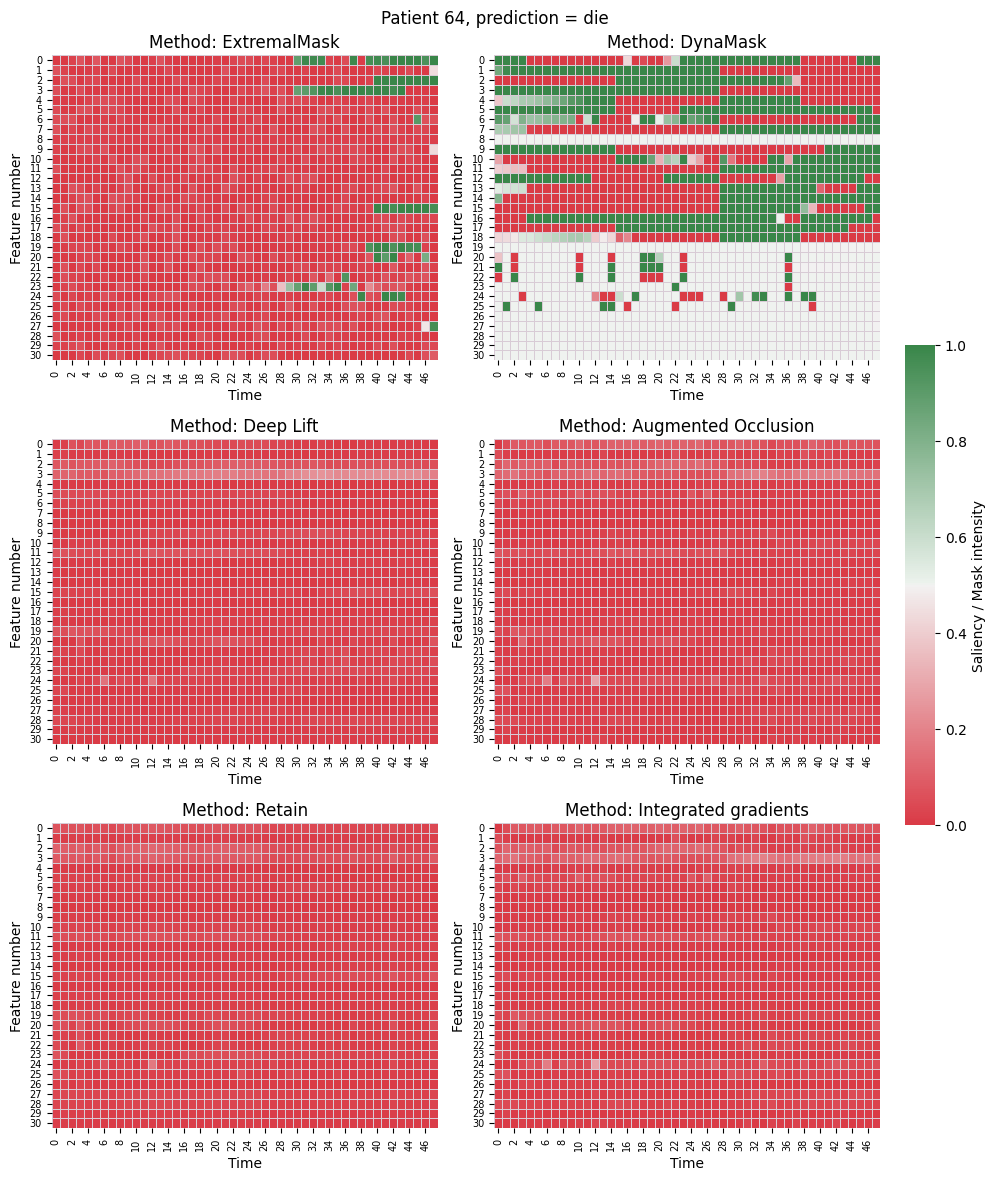

In [16]:
saliencies = {
    "ExtremalMask": extremal_mask_attr_mimic[POS_ID].T,
    "DynaMask": dyna_mask_attr_mimic[POS_ID].T,
    "Deep Lift": deep_lift_attr_mimic[POS_ID].T,
    "Augmented Occlusion": aug_occlusion_attr_mimic[POS_ID].T,
    "Retain": retain_attr_mimic[POS_ID].T,
    "Integrated gradients": aug_occlusion_attr_mimic[POS_ID].T,
}
plot_heatmap(saliencies, title=f"Patient {POS_ID}, prediction = die")

### Compare many explainer methods on a negative sample (Figure 6 in the Appendix)

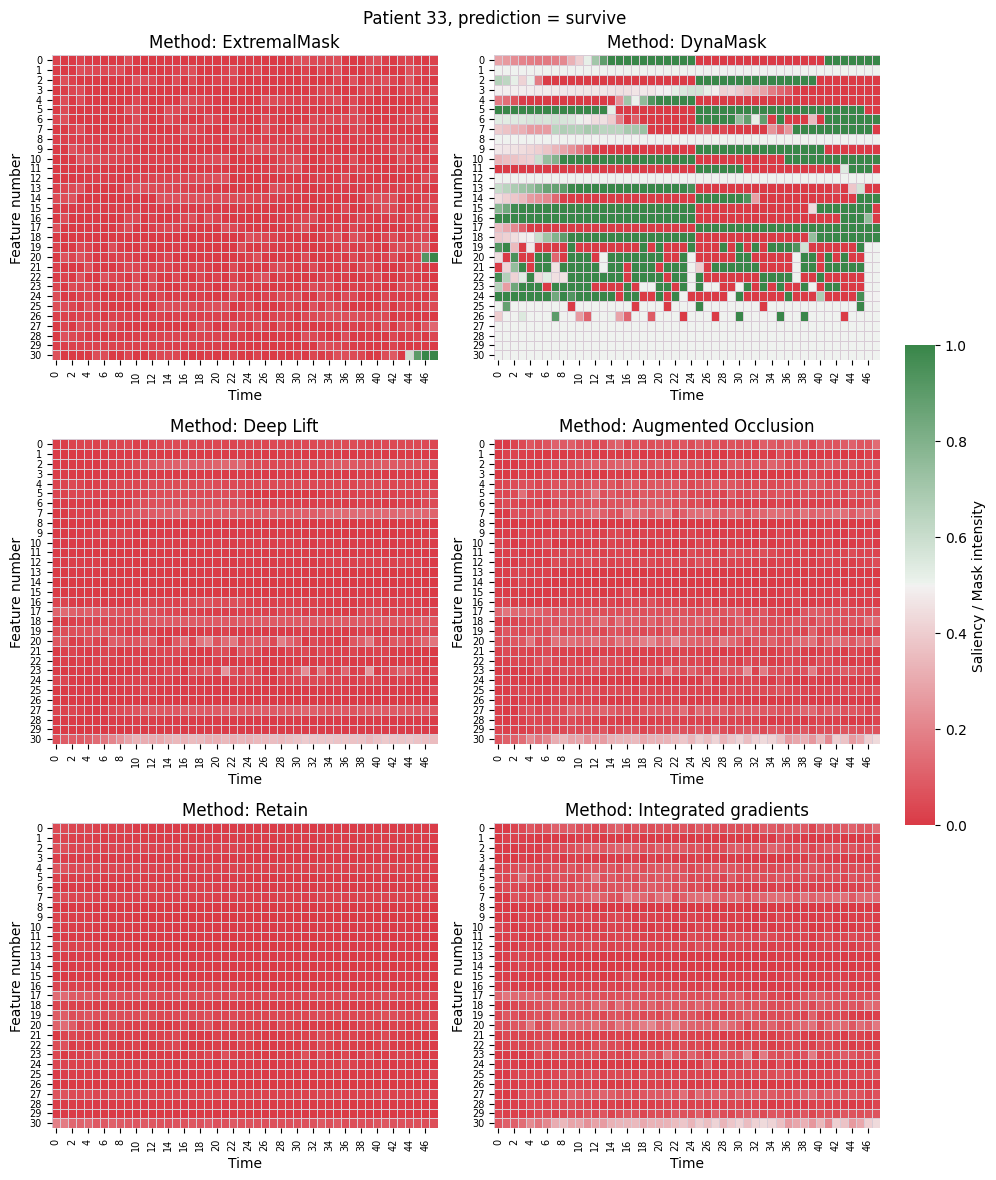

In [17]:
saliencies = {
    "ExtremalMask": extremal_mask_attr_mimic[NEG_ID].T,
    "DynaMask": dyna_mask_attr_mimic[NEG_ID].T,
    "Deep Lift": deep_lift_attr_mimic[NEG_ID].T,
    "Augmented Occlusion": aug_occlusion_attr_mimic[NEG_ID].T,
    "Retain": retain_attr_mimic[NEG_ID].T,
    "Integrated gradients": aug_occlusion_attr_mimic[NEG_ID].T,
}
plot_heatmap(saliencies, title=f"Patient {NEG_ID}, prediction = survive")

### Detailed visualization of saliency predictions (Figure 7 in the Appendix)

In [18]:
from tint.datasets.mimic3 import lab_IDs, vital_IDs

# Load all feature names for plotting
other_features = ["Gender", "Age", "Ethnicity", "First ICU stay"]
feature_names = np.array(lab_IDs + vital_IDs + other_features)

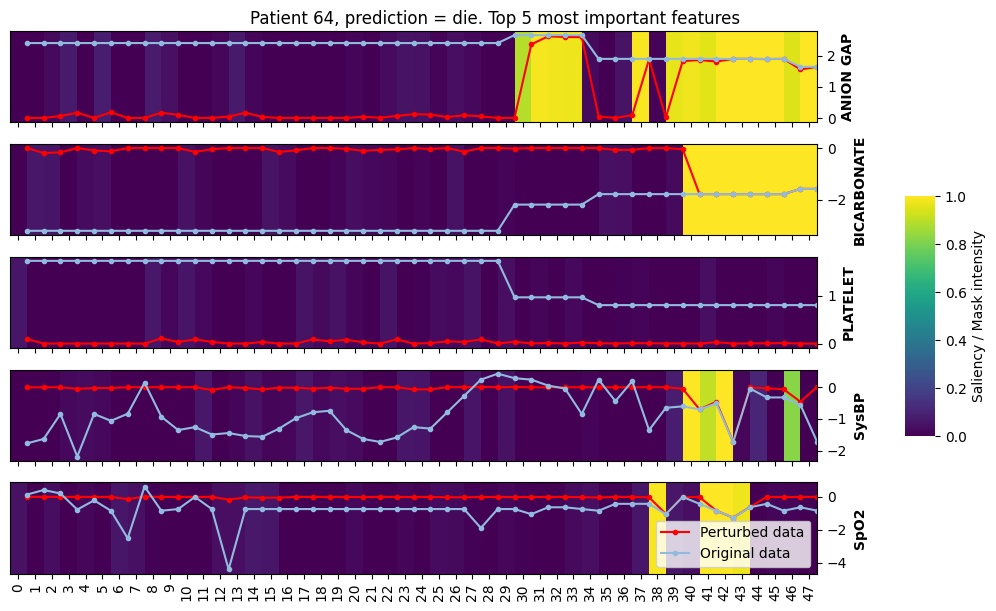

In [19]:
from tint.utils.plotting import plot_saliency

# Take the top 5 important features from the mean attribution plot below
imp_feat_idx = np.array([0, 2, 11, 20, 24])
plot_saliency(
    ts_data=extremal_mimic_batch[POS_ID].T[imp_feat_idx],
    saliency_list=extremal_mask_attr_mimic[POS_ID].T[imp_feat_idx],
    perturbed=extremal_x1_mimic[POS_ID].T[imp_feat_idx],
    suptitle=f"Patient {POS_ID}, prediction = die. Top 5 most important features",
    feature_names=np.array(feature_names)[imp_feat_idx],
)

### Investigate ANION GAP feature at a closer look (Figure 9 in the Appendix)

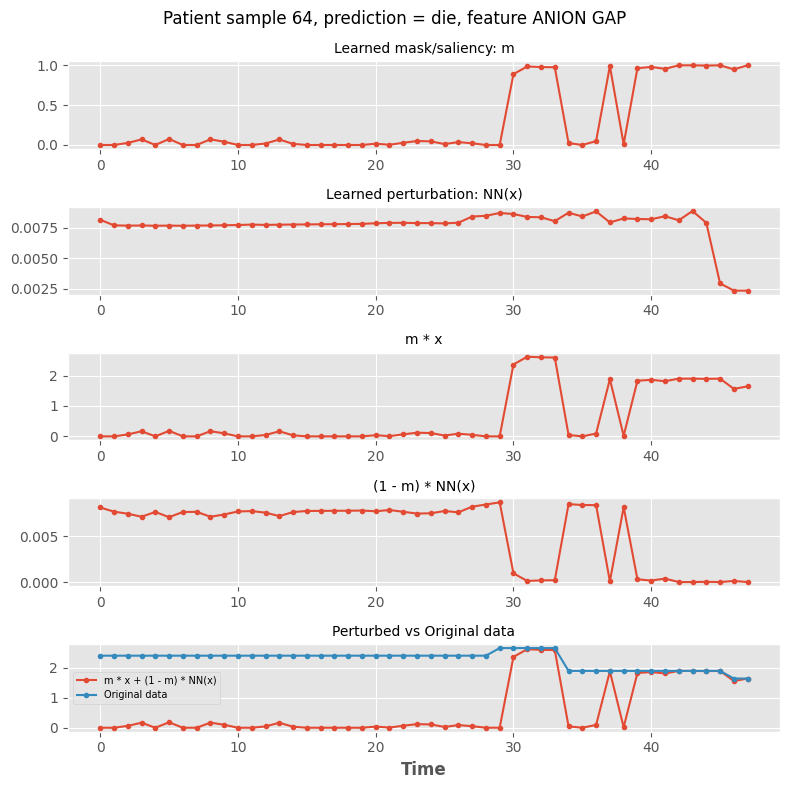

In [20]:
from tint.utils.plotting import plot_components

feat_no = 0  # ANION GAP index
plot_components(
    orig=extremal_mimic_batch[POS_ID].T[feat_no],
    perturbed=extremal_x1_mimic[POS_ID].T[feat_no],
    mask=extremal_mask_attr_mimic[POS_ID].T[feat_no],
    perturbation=extremal_perturbation_mimic[POS_ID].T[feat_no],
    suptitle=f"Patient sample {POS_ID}, prediction = die, feature {feature_names[feat_no]}",
    figsize=(8, 8),
)

### Plotting alternative saliency (Figure 8 in the Appendix)

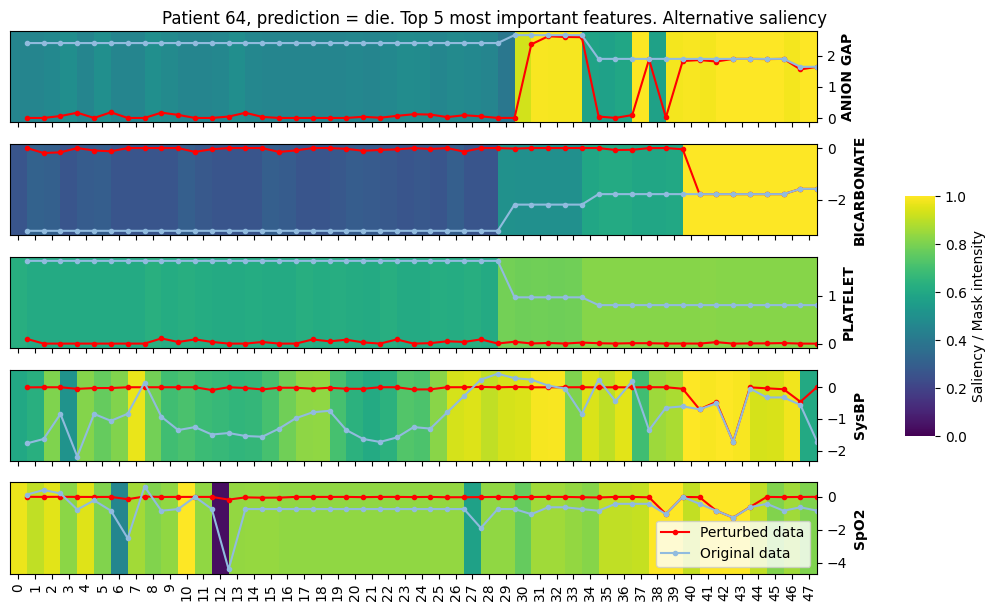

In [21]:
plot_saliency(
    ts_data=extremal_mimic_batch[POS_ID].T[imp_feat_idx],
    saliency_list=extremal_alternative_mimic[POS_ID].T[imp_feat_idx],
    perturbed=extremal_x1_mimic[POS_ID].T[imp_feat_idx],
    suptitle=f"Patient {POS_ID}, prediction = die. Top 5 most important features. Alternative saliency",
    feature_names=np.array(feature_names)[imp_feat_idx],
)

###  Plotting feature importances for identifying deaths in patients (Figure 2 in our paper)

Reproducing Figure 5 from the original paper

In [22]:
# Filter data to postive (dead) patients which have been
# correctly classified by the classifer in question
dead_indices = th.where(mimic_cls_predictions == 1)[0]
dead_attr = extremal_mask_attr_mimic[dead_indices]
dead_attr.shape

torch.Size([117, 48, 31])

### Mean attributions for mask computed with linear and exponential time decay (Figure 2)

No decay
['HeartRate' 'SysBP' 'PLATELET' 'BICARBONATE' 'ANION GAP']
Linear decay
[19 20  2  0 11] ['HeartRate' 'SysBP' 'BICARBONATE' 'ANION GAP' 'PLATELET']
Exponential decay
[19 20 11  2  0] ['HeartRate' 'SysBP' 'PLATELET' 'BICARBONATE' 'ANION GAP']


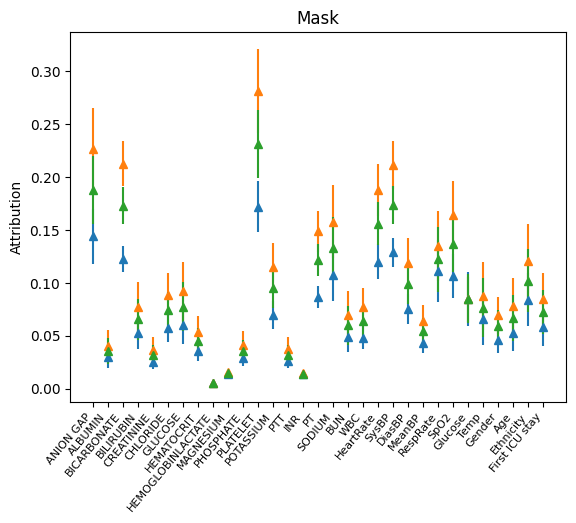

In [23]:
from tint.utils.plotting import plot_mean_attributions

plot_mean_attributions(
    dead_attr, decay=True, xtick_labels=feature_names, debug=True, title="Mask"
)

The 5 most important features for identifying deaths using mask saliency are identified above the plot for no, linear, and exponential decay respectively.

### Mean attributions for alternative computed with linear and exponential time decay (Figure 2)

In [24]:
mimic_batch, perturbation_mimic, mask_mimic, x1_mimic, x2_mimic = compute_perturbations(
    data=x_test_mimic,
    mask_net=extremal_mask_mask_net_mimic,
    perturb_net=extremal_mask_mask_net_mimic.net.model,
    batch_idx=None,  # Set to None to compute perturbations for the whole dataset
)
alternative_mimic = compute_alternative(
    batch=mimic_batch, mask=mask_mimic, perturbation=perturbation_mimic, p=np.inf
)
# Cut alternative to the dead/positive cases
dead_alternative = alternative_mimic[dead_indices]

No decay
['SpO2' 'ALBUMIN' 'HEMOGLOBINLACTATE' 'INR' 'MAGNESIUM']
Linear decay
[24  1 14  9  8] ['SpO2' 'ALBUMIN' 'INR' 'MAGNESIUM' 'HEMOGLOBINLACTATE']
Exponential decay
[24  1  8 14  9] ['SpO2' 'ALBUMIN' 'HEMOGLOBINLACTATE' 'INR' 'MAGNESIUM']


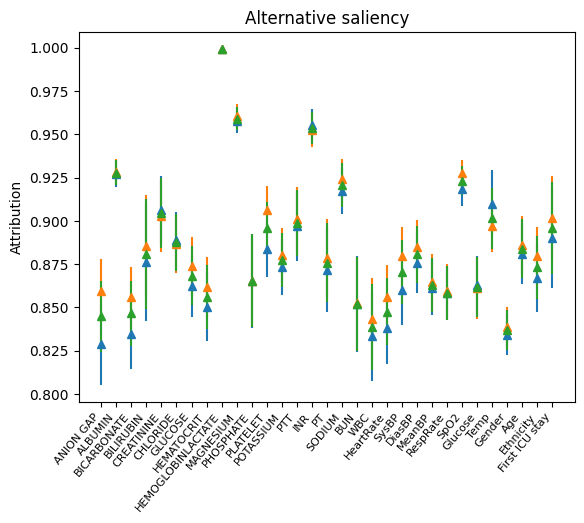

In [25]:
plot_mean_attributions(
    dead_alternative,
    decay=True,
    xtick_labels=feature_names,
    debug=True,
    title="Alternative saliency",
)

The 5 most important features for identifying deaths using the alternative saliency are identified above the plot for no, linear, and exponential decay respectively.

## Hidden Markov Model (HMM) dataset

Some additional visualizations of the extremal method. This time on a synthetic, whitebox dataset.

In [26]:
SEED = 42
FOLD = 0
hmm_batch_size = 100  # Used during training

In [27]:
# Load HMM data
from pytorch_lightning import seed_everything
from tint.datasets import HMM

# Make sure to seed before data generation to return numpy and other libraries to their original state
# in order to generate the same data with the same seed as the process for training the models
seed_everything(seed=SEED, workers=True)

hmm = HMM(n_folds=5, fold=FOLD, seed=SEED)
hmm.download(split="test")
inputs_hmm = hmm.preprocess(split="test")["x"]
y_hmm = hmm.preprocess(split="test")["y"]
true_saliency_hmm = hmm.true_saliency(split="test")
print("batch size, time series length, no. features", inputs_hmm.size())

Seed set to 42


/home/paulius/projects/fact/factai/tint/data/hmm
batch size, time series length, no. features torch.Size([200, 200, 3])


In [28]:
import os

import torch.nn as nn
from experiments.hmm.classifier import StateClassifierNet
from tint.attr.models import ExtremalMaskNet
from tint.models import MLP, RNN

classifier_hmm = StateClassifierNet(
    feature_size=3,
    n_state=2,
    hidden_size=200,
    regres=True,
    loss="cross_entropy",
    lr=0.0001,
    l2=1e-3,
)

classifier_hmm = get_model(
    trainer=None,
    model=classifier_hmm,
    model_name="classifier",
    data_name="hmm",
    seed=SEED,
    fold=FOLD,
    datamodule=None,
)
classifier_hmm.eval()

extremal_mask_net_hmm = ExtremalMaskNet(
    forward_func=classifier_hmm,
    model=nn.Sequential(
        RNN(
            input_size=inputs_hmm.shape[-1],
            rnn="gru",
            hidden_size=inputs_hmm.shape[-1],
            bidirectional=True,
        ),
        MLP([2 * inputs_hmm.shape[-1], inputs_hmm.shape[-1]]),
    ),
    lambda_1=1.0,
    lambda_2=1.0,
    optim="adam",
    lr=0.01,
)
checkpoint_path = (
    f"experiments/checkpoints/hmm_extremal_mask_{SEED}_1.0_1.0_{FOLD}.ckpt"
)

# Make sure the mask is initialized
extremal_mask_net_hmm.net.init(input_size=inputs_hmm.shape, batch_size=hmm_batch_size)
extremal_mask_net_hmm.load_state_dict(th.load(checkpoint_path))

# Compute the attributions using the loaded network
extremal_mask_net_hmm.eval()
extremal_attr_hmm = extremal_mask_net_hmm.net.representation()

Trying to load experiments/checkpoints/hmm_classifier_42_0.ckpt
classifier has loaded the saved weights on hmm dataset with fold = 0, if applicable, lambda 1 = None and lambda 2 = None.


### Visualize ExtremalMask performance (Figure 10 in the Appendix)

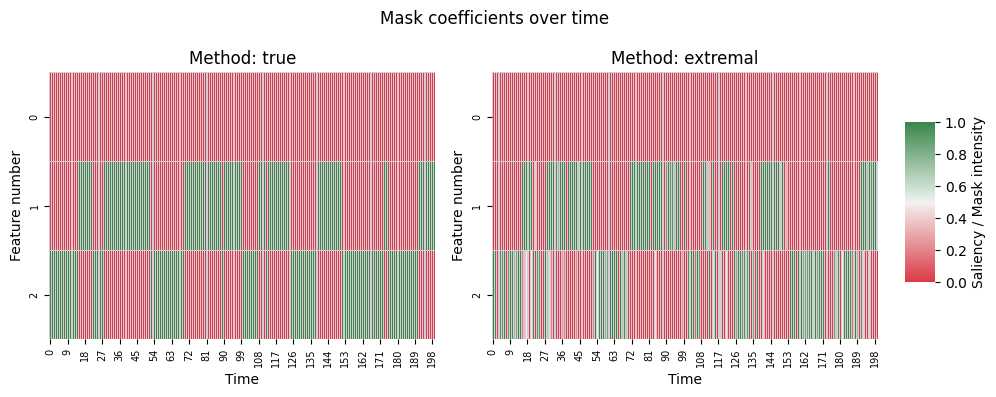

In [29]:
# Visualize true and predicted saliency
SAL_ID = 12
saliencies = {
    "true": true_saliency_hmm[SAL_ID].T,
    "extremal": extremal_attr_hmm[SAL_ID].T,
}
plot_heatmap(saliencies)

### Visualize learned perturbations and saliency in detail for HMM (Figure 11 and 12 in the Appendix)

In [30]:
# x, NN(x), m, x * m + (1 - m) * NN(x), x * (1 - m) + m * NN(x)
hmm_batch, perturbation_hmm, mask_hmm, x1_hmm, x2_hmm = compute_perturbations(
    data=inputs_hmm,
    mask_net=extremal_mask_net_hmm,
    perturb_net=extremal_mask_net_hmm.net.model,
    batch_idx=0,
)
# 1 - (1 - m) * |NN(x) - x|
# Intuition: the higher this value, the more perturbed the data is.
extremal_alternative_hmm = compute_alternative(
    batch=hmm_batch,
    mask=mask_hmm,
    perturbation=perturbation_hmm,
)

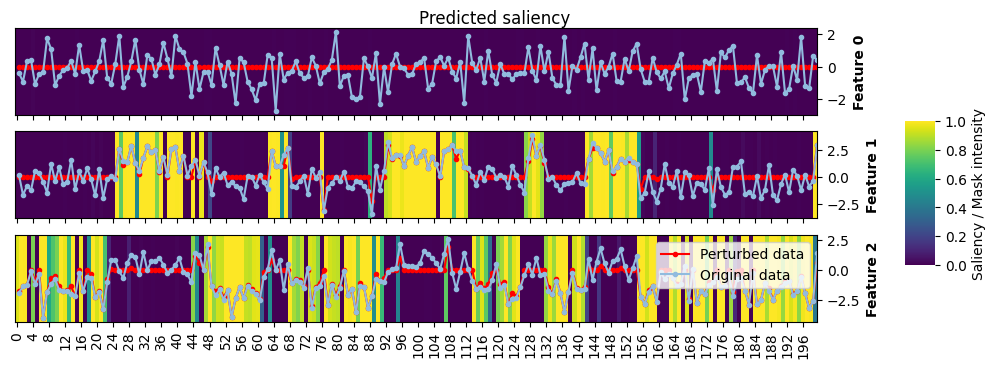

In [31]:
SAL_ID = 14
plot_saliency(
    ts_data=hmm_batch[SAL_ID].T,
    saliency_list=mask_hmm[SAL_ID].T,
    perturbed=x1_hmm[SAL_ID].T,
    suptitle="Predicted saliency",
)

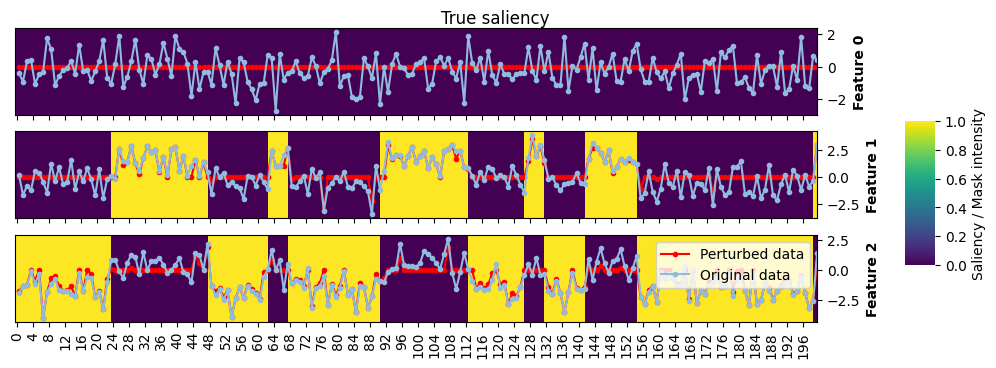

In [32]:
plot_saliency(
    ts_data=hmm_batch[SAL_ID].T,
    saliency_list=true_saliency_hmm[SAL_ID].T,
    perturbed=x1_hmm[SAL_ID].T,
    suptitle="True saliency",
)

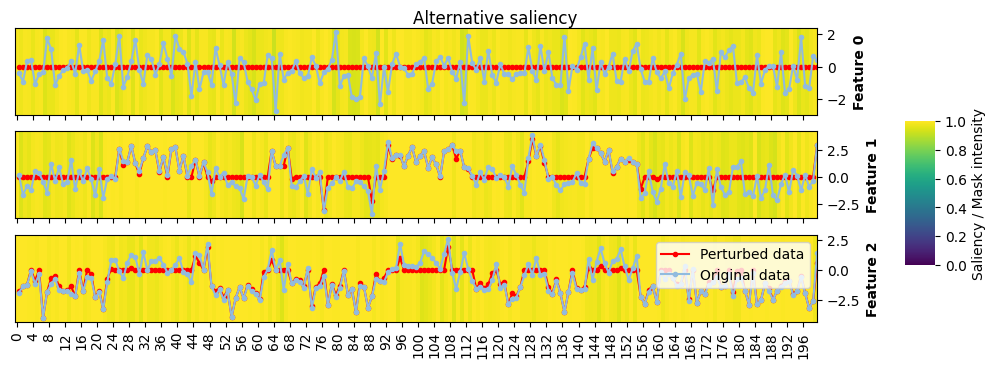

In [33]:
plot_saliency(
    ts_data=hmm_batch[SAL_ID].T,
    saliency_list=extremal_alternative_hmm[SAL_ID].T,
    perturbed=x1_hmm[SAL_ID].T,
    suptitle="Alternative saliency",
)

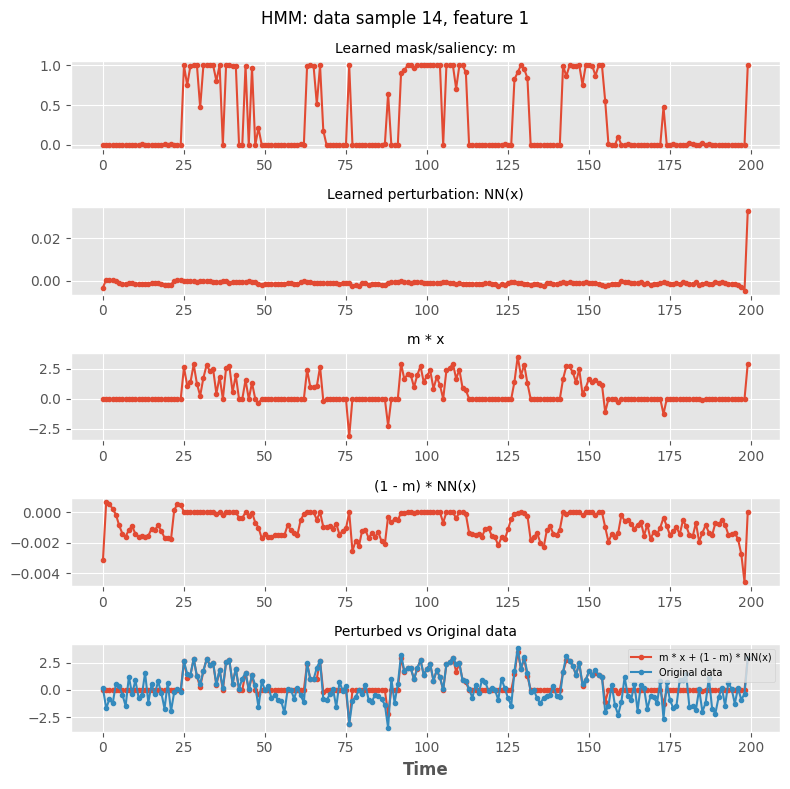

In [34]:
feat_no = 1  # Which specific time series to investigate?
plot_components(
    orig=hmm_batch[SAL_ID].T[feat_no],
    perturbed=x1_hmm[SAL_ID].T[feat_no],
    mask=mask_hmm[SAL_ID].T[feat_no],
    perturbation=perturbation_hmm[SAL_ID].T[feat_no],
    suptitle=f"HMM: data sample {SAL_ID}, feature {feat_no}",
    figsize=(8, 8),
)